<a href="https://colab.research.google.com/github/egwebb19/CUBoulder_MSDS/blob/main/titanicProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import statsmodels.formula.api as smf

Mounted at /content/drive


In [3]:
# I definitely stole this from online but it looks really cool so I'm keeping it.
# Credit: https://www.kaggle.com/code/mosammo/randomforest-eda
def barPlot(df,column,hue=None,size=(10,6), title=None):
  if not title:
    title = f'Distribution of {column}'
  plt.figure(figsize=size)
  ax = sns.countplot(data=df,x=column,hue=hue)
  for p in ax.patches:
    height = p.get_height()
    percent = f'{100*height/len(df):.1f}%'
    ax.text(p.get_x() + p.get_width()/2, height/2, percent, ha='center',va='center',
            fontsize=10,color='white')
  plt.xlabel(column)
  plt.ylabel('Count')
  plt.title(title)
  plt.show()

For this project, I've chosen to analyze the "Titanic: Machine Learning from Disaster" dataset from Kaggle. The link to the dataset is here: https://www.kaggle.com/competitions/titanic/data

Let's start by loading the data and doing some exploratory analysis.

In [4]:
train = pd.read_csv("/content/drive/MyDrive/MSDS/supervisedLearning/train.csv");
test = pd.read_csv("/content/drive/MyDrive/MSDS/supervisedLearning/test.csv");
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can already see there are some NaNs in the data-- particularly in the "Cabin" column. Let's explore this further, and see if we can't clean up the data a bit.

In [5]:
train.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [6]:
test.isna().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1
Cabin,327


In [7]:
print("Unique tickets in train: " + str(len(np.unique(train["Ticket"]))))
print("Length of training data: " + str(len(train)))

Unique tickets in train: 681
Length of training data: 891


There are so many NaNs in "Cabin," with no easy way to fill them, so let's instead get rid of that column entirely. We'll also exclude "Name" and "Ticket" from our search, as both are too unique to be of any actionable help.

In [8]:
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'];
train = train[features + ['Survived']];
test = test[features]

Now let's look at filling in the missing data.

In [9]:
# Fill the NaNs in the age column with the median age from the training data.
test['Age'] = test['Age'].fillna(train['Age'].median());
train['Age'] = train['Age'].fillna(train['Age'].median());
train.dropna(inplace=True); # Drop other NaN columns
test.dropna(inplace=True);

Additionally, let's convert age from a continuous to categorical variable.

In [10]:
ageGroups = ['{0} - {1}'.format(ii,ii+4) for ii in range(0,70,5)]
ageGroups[-1] = ageGroups[-1][:2] + '+'
ageGroups

train.Age = pd.cut(train.Age,range(0,75,5),labels=ageGroups)
test.Age = pd.cut(test.Age,range(0,75,5),labels=ageGroups)

The data has been cleaned! Let's make a few plots to better understand the distribution of our data.

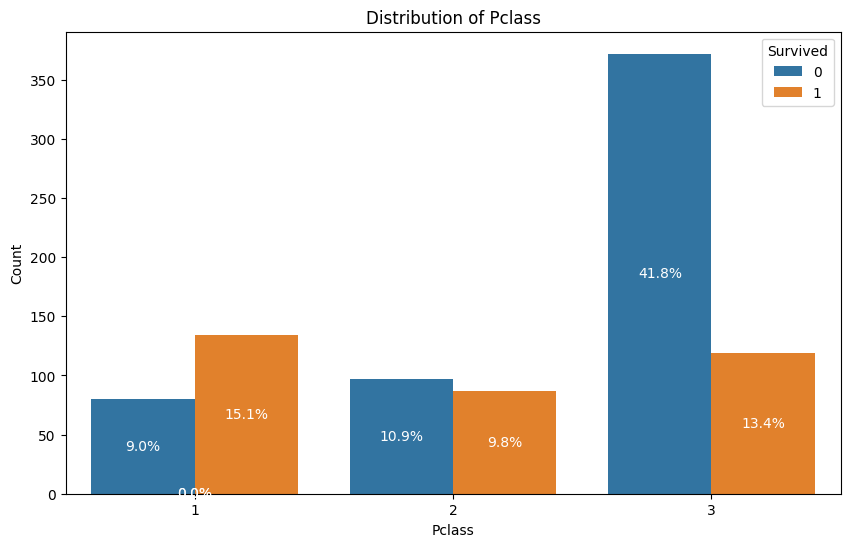

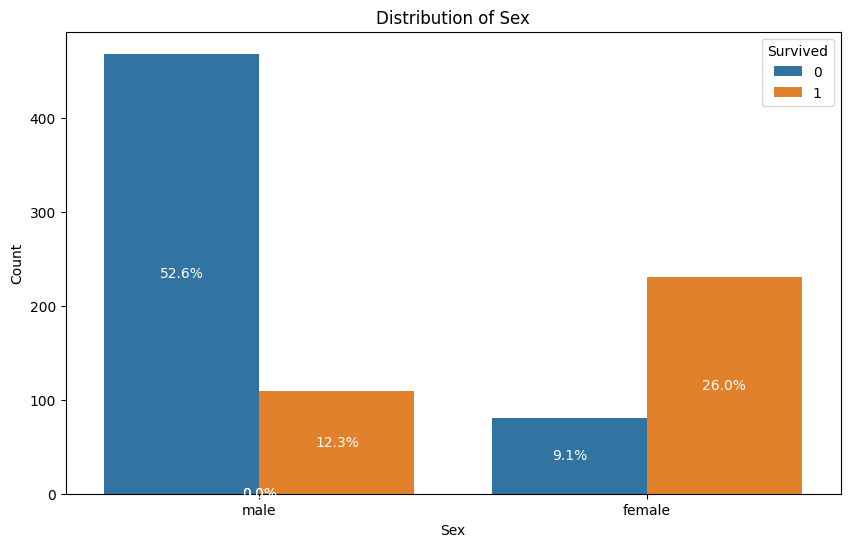

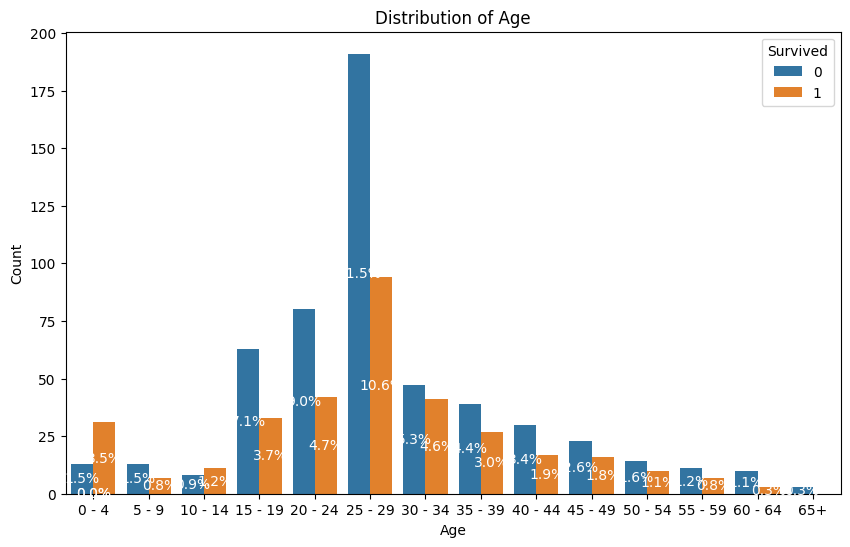

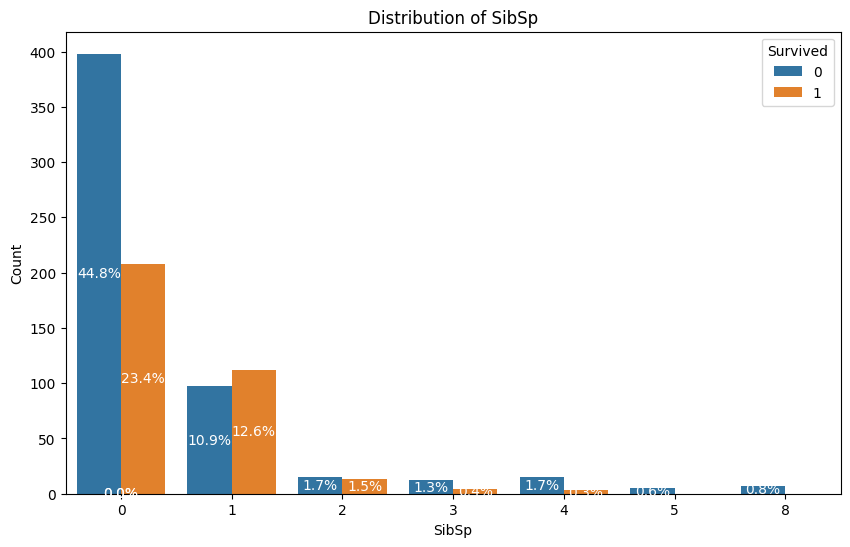

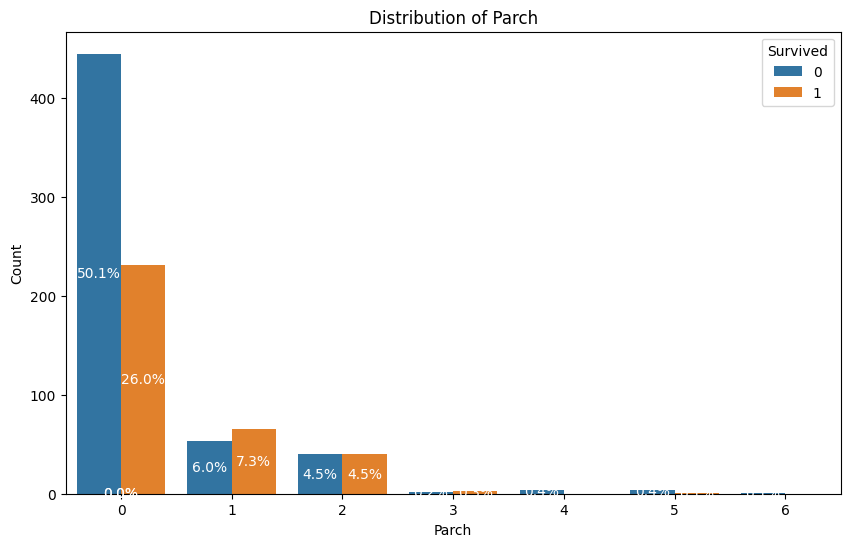

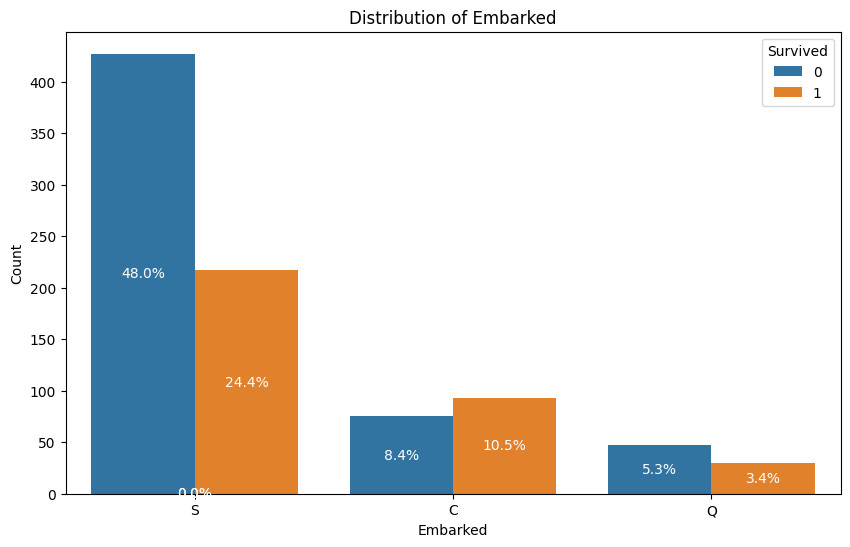

In [11]:
for col in train.drop(columns=['Fare','Survived']).columns:
  barPlot(train,column=col,hue='Survived')

Okay, we've got more of a feel for the data. Now we'll start looking at how the features of the data are correlated with the survival of the passenger. The first step to do this is to encode categorical labels like Sex, Age, and Embarked with numbers, so corr can understand them.

In [12]:
for feat in ['Sex','Age','Embarked']:
  le = LabelEncoder()
  train[feat] = le.fit_transform(train[feat])
  test[feat] = le.fit_transform(test[feat])

<Axes: >

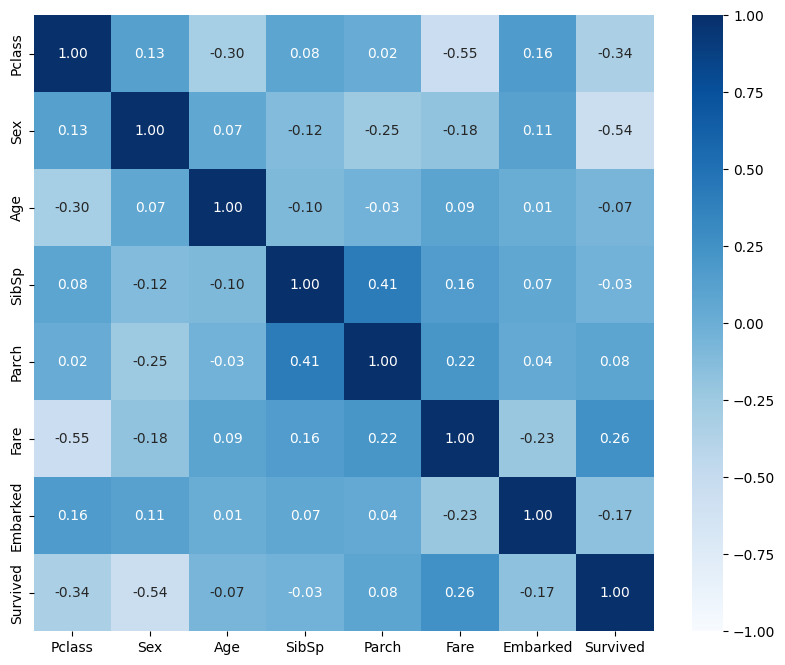

In [13]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(),vmin=-1,vmax=1,annot=True,fmt='.2f',cmap='Blues')

In [14]:
# Which variable is the most correlated with passenger survival?
corrMat = train.corr()
np.fill_diagonal(corrMat.values,0)
colIdx = abs(corrMat['Survived'])==max(abs(corrMat['Survived']))
weFind = np.where(colIdx.values==True)[0][0]
colNames = list(corrMat.columns)
print("The most correlated variable is: " + colNames[weFind])
# After sex, the next most correlated variables are passenger class and fare,
# which are themselves highly fairly correlated.

The most correlated variable is: Sex


Let's fit a very simple model to this data, simply looking at the passenger's sex.

In [16]:
fTrain, fTest = train_test_split(train,test_size=0.2,random_state=1234)

olsModel = smf.ols("Survived ~ Sex",data=fTrain).fit()
olsModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     314.9
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           1.40e-58
Time:                        00:28:35   Log-Likelihood:                -365.21
No. Observations:                 711   AIC:                             734.4
Df Residuals:                     709   BIC:                             743.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7441      0.025     29.282      0.000       0.694       0.794
Sex           -0.5625      0.032    -17.746      0.000      -0.625      -0.500
==============================================================================
Omnibus:                       19.771   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.807
Skew:                           0.418   Prob(JB):                     3.03e-05
Kurtosis:                       3.069   Cond. No.                         3.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hmm... that's not a great R-squared value. What happens if we include some of the other highly correlated variables?

In [19]:
# I've multiplied Pclass*Fare here to account for some of their innate correlation.
olsModel2 = smf.ols("Survived~Sex+Pclass*Fare",data=fTrain).fit()
olsModel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     106.1
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           9.10e-71
Time:                        00:34:44   Log-Likelihood:                -328.52
No. Observations:                 711   AIC:                             667.0
Df Residuals:                     706   BIC:                             689.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0094      0.061     16.535      0.000       0.890       1.129
Sex            -0.5350      0.031    -17.443      0.000      -0.595      -0.475
Pclass         -0.1186      0.024     -4.941      0.000      -0.166      -0.071
Fare            0.0016      0.001      1.807      0.071      -0.000       0.003
Pclass:Fare    -0.0012      0.001     -1.604      0.109      -0.003       0.000
==============================================================================
Omnibus:                       35.516   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.583
Skew:                           0.571   Prob(JB):                     2.54e-09
Kurtosis:                       3.184   Cond. No.                         438.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Okay, that's a little better. But Fare and Pclass:Fare don't seem to be statistically significant features. One more try.

In [20]:
olsModel3 = smf.ols("Survived~Sex+Pclass",data=train).fit()
olsModel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     255.1
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           3.12e-88
Time:                        00:36:49   Log-Likelihood:                -417.79
No. Observations:                 889   AIC:                             841.6
Df Residuals:                     886   BIC:                             855.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0822      0.041     26.706      0.000       1.003       1.162
Sex           -0.5163      0.027    -18.789      0.000      -0.570      -0.462
Pclass        -0.1577      0.016    -10.035      0.000      -0.189      -0.127
==============================================================================
Omnibus:                       40.945   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.720
Skew:                           0.554   Prob(JB):                     1.18e-10
Kurtosis:                       3.071   Cond. No.                         9.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Well, that's pretty much the same as the previous model. Oh well. Let's try a more complicated model, like a Random Forest. First, we need to split the training data (as the testing data doesn't have the 'Survived' column, thus we cannot *know* our accuracy).

In [21]:
X = train.drop(columns=['Survived'])
y = train.Survived

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

In [22]:
# This is just a standard Random Forest, using 100 estimators.
rf = RandomForestClassifier(random_state=1234).fit(X_train,y_train)

In [23]:
# How'd we do?
yPred = rf.predict(X_test)
acc = accuracy_score(y_test,yPred)
print("Accuracy: ", acc)

Accuracy:  0.8258426966292135


Not bad! How important were each of the features to the model?

<Axes: >

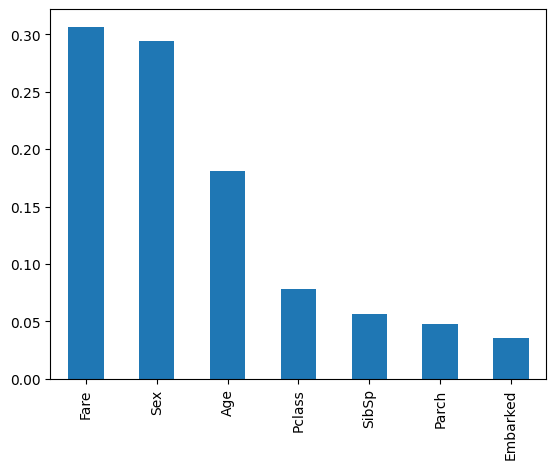

In [24]:
rfImpFeatures = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending=False)
rfImpFeatures.plot.bar()

Well that's a little unexpected, no? Given the correlation matrix, I would have thought Sex to be most important, followed by Pclass and then Fare. Clearly this Random Forest felt differently. No matter-- let's see if we can make this model do a little better by tuning some of our hyperparameters.

In [25]:
param_dist = {'n_estimators': stats.randint(50,500),
              'max_depth': stats.randint(1,20),
              'min_samples_split': stats.randint(2,10)}
rfH = RandomForestClassifier()

hypSearch = RandomizedSearchCV(rf,param_distributions=param_dist,
                               n_iter=5,cv=5)
hypSearch.fit(X_train,y_train)

print('Best hyperparameters: ', hypSearch.best_params_)

Best hyperparameters:  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 356}


In [26]:
newRF = RandomForestClassifier(max_depth=10,min_samples_split=5,
                               n_estimators=356,random_state=1234)
newRF.fit(X_train,y_train)

yPred = newRF.predict(X_test)
acc = accuracy_score(y_test,yPred)
print("Accuracy: ", acc)

Accuracy:  0.8539325842696629


That's an increase in accuracy of about 3%-- which is not bad, but not huge. This tells me that it's going to be very difficult to get much better accuracy on the test data than this.

<Axes: >

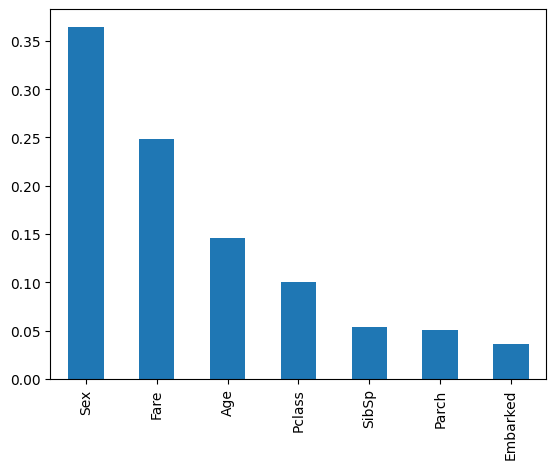

In [27]:
rfImpFeatures = pd.Series(newRF.feature_importances_, index = X_train.columns).sort_values(ascending=False)
rfImpFeatures.plot.bar()